In [1]:
import matplotlib.pylab as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)
import shap







In [2]:
# Display SHAP JS plots
shap.initjs()

# Show all columns
pd.set_option('display.max_columns', None)

# Load data
df= pd.read_csv(r"C:\Users\dzinyela_1\Downloads\Zakari\Personal_Household_Cleaned_ready.csv")
##df = pd.read_csv(r"C:\Users\dzinyela_1\Downloads\Zakari\Personal_Household_USE.csv")



In [3]:
df

Household_Size_1  Household_Size_2  Household_Size_3  \
0                    0                 0                 1   
1                    0                 0                 1   
2                    0                 0                 1   
3                    0                 0                 1   
4                    0                 0                 1   
...                ...               ...               ...   
4613                 0                 0                 1   
4614                 0                 0                 1   
4615                 0                 0                 1   
4616                 0                 0                 1   
4617                 1                 1                 1   

      Household_Size_Above 3  Monthly_Income_less_1000  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   
...                      ...                       ...   
4613                       0                         0   
4614                       0                         0   
4615                       0                         0   
4616                       0                         0   
4617                       1                         0   

      Monthly_Income_less_2000  Monthly_Income_greater_2000  \
0                            0                            1   
1                            0                            1   
2                            0                            1   
3                            0                            1   
4                            0                            1   
...                        ...                          ...   
4613                         0                            1   
4614                         1                            0   
4615                         1                            0   
4616                         1                            0   
4617                         1                            0   

      Transport_Expenditure_less_100  Transport_Expenditure_less_200  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   
...                              ...                             ...   
4613                               0                               0   
4614                               1                               0   
4615                               1                               0   
4616                               1                               0   
4617                               0                               1   

      Transport_Expenditure_less_300  Transport_Expenditure 300_500  \
0                                  0                              1   
1                                  0                              1   
2                                  0                              1   
3                                  0                              1   
4                                  0                              1   
...                              ...                            ...   
4613                               1                              0   
4614                               0                              0   
4615                               0                              0   
4616                               0                              0   
4617                               0                              0   

      Transport_Expenditure greater 500  No_Vehicles _Owned  Gender_Male  \
0            

In [4]:
pip install Pandoc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
df.drop(['Household_Size_2',
    'Household_Size_3',
    'Household_Size_Above 3',
    'No_Vehicles _Owned',
    'Driving_licence_Yes',
    'Currently_Edu_Basic school_Yes',
    'Currently_Edu_Not Edu_Yes',
    'Age_less_equal_15',
    'Cell_phone_Yes_with Int.','household_Head_Yes','Age_less_equall_51','Age_less_equall_to_31','Vehicle_Access_Yes'
], axis=1, inplace=True)

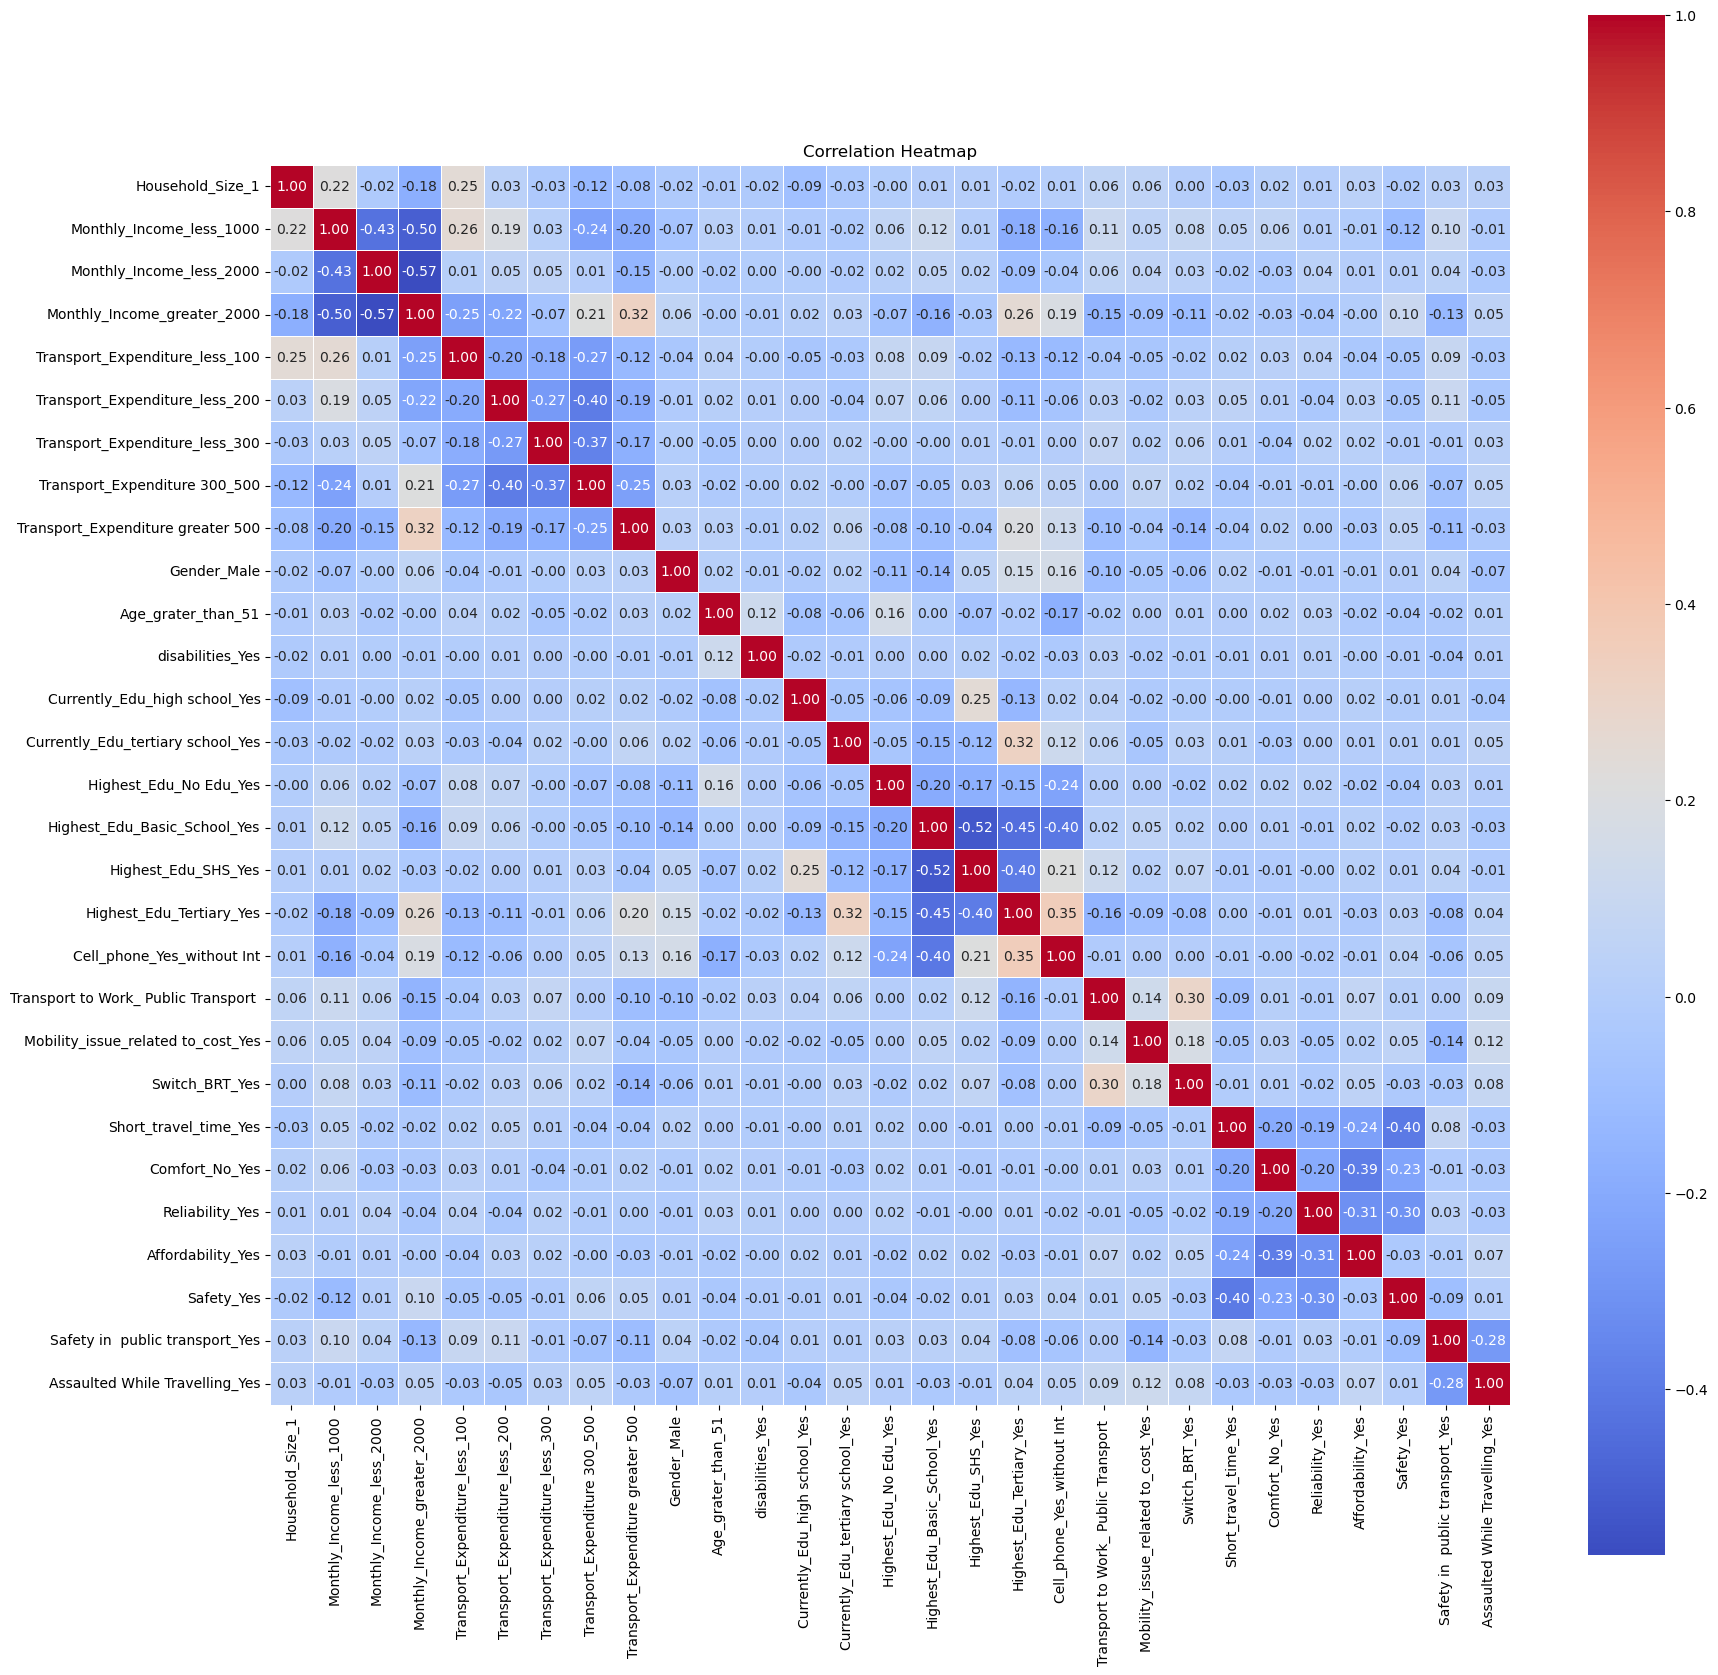

In [6]:
correlation_matrix = df.corr(numeric_only=True)


plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


In [7]:
df.columns

Index(['Household_Size_1', 'Monthly_Income_less_1000',
       'Monthly_Income_less_2000', 'Monthly_Income_greater_2000',
       'Transport_Expenditure_less_100', 'Transport_Expenditure_less_200',
       'Transport_Expenditure_less_300', 'Transport_Expenditure 300_500',
       'Transport_Expenditure greater 500', 'Gender_Male',
       'Age_grater_than_51', 'disabilities_Yes',
       'Currently_Edu_high school_Yes', 'Currently_Edu_tertiary school_Yes',
       'Highest_Edu_No Edu_Yes', 'Highest_Edu_Basic_School_Yes',
       'Highest_Edu_SHS_Yes', 'Highest_Edu_Tertiary_Yes',
       'Cell_phone_Yes_without Int', 'Transport to Work_ Public Transport ',
       'Mobility_issue_related to_cost_Yes', 'Switch_BRT_Yes',
       'Short_travel_time_Yes', 'Comfort_No_Yes', 'Reliability_Yes',
       'Affordability_Yes', 'Safety_Yes', 'Safety in  public transport_Yes',
       'Assaulted While Travelling_Yes'],
      dtype='object')

In [8]:
# Features and target
X = df.drop('Switch_BRT_Yes', axis=1)
y = df['Switch_BRT_Yes']
X_display = X.copy()  # for SHAP display


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Create DMatrix for XGBoost
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}


In [10]:
# Train model
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)

# Predict on test set
y_pred_prob = model.predict(d_test)
y_pred = (y_pred_prob > 0.5).astype(int)


[0]	test-logloss:0.30493
[100]	test-logloss:0.27046
[182]	test-logloss:0.26863


In [11]:
# Evaluation metrics
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC Score: {auc_score:.4f}")



Confusion Matrix:
[[  2  82]
 [  2 838]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.02      0.05        84
           1       0.91      1.00      0.95       840

    accuracy                           0.91       924
   macro avg       0.71      0.51      0.50       924
weighted avg       0.87      0.91      0.87       924


Accuracy: 0.9091
Recall: 0.9976
AUC Score: 0.7494


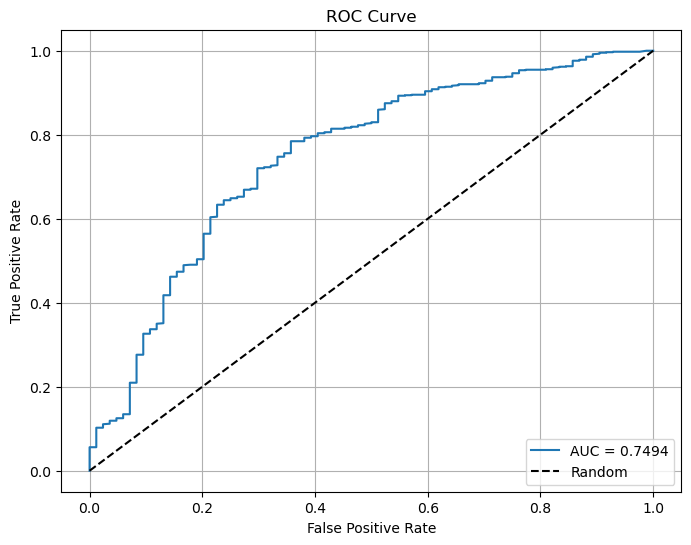

In [12]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [13]:
# SHAP analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)




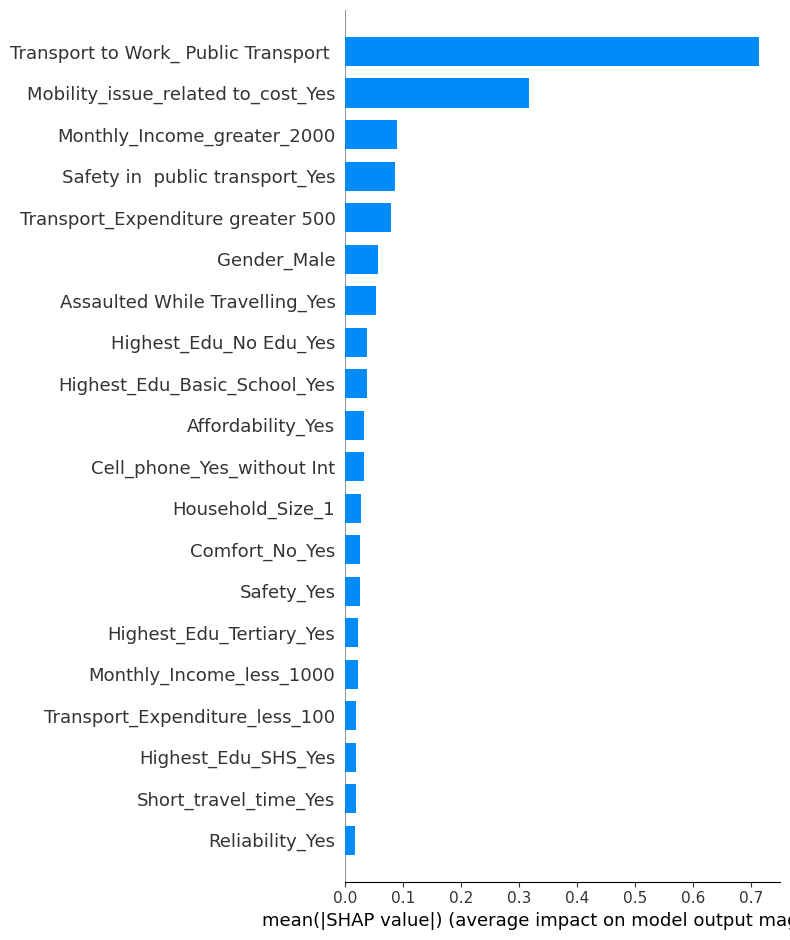

In [14]:
# SHAP plots
shap.summary_plot(shap_values, X_display, plot_type="bar")



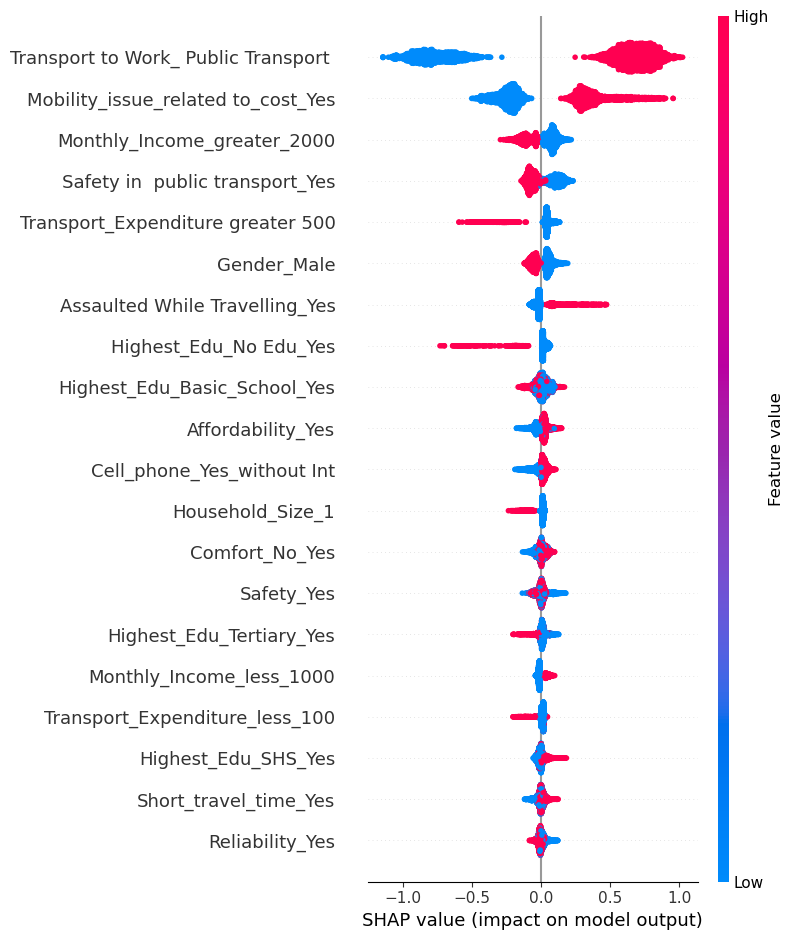

In [15]:
shap.summary_plot(shap_values, X)

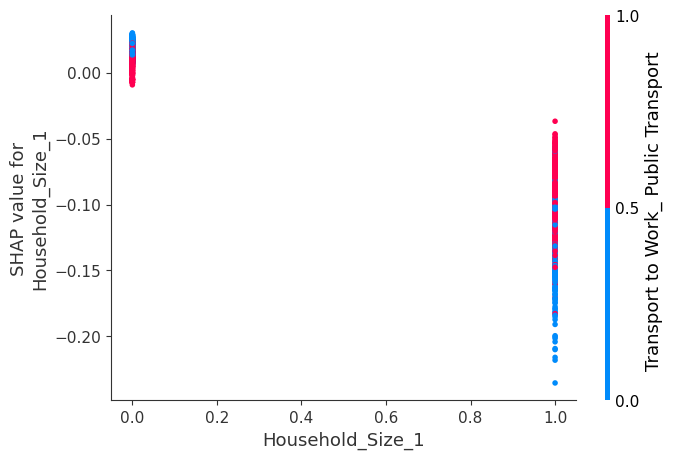

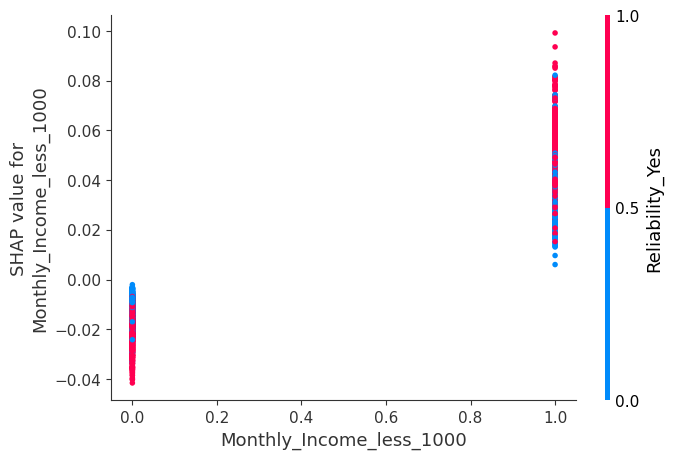

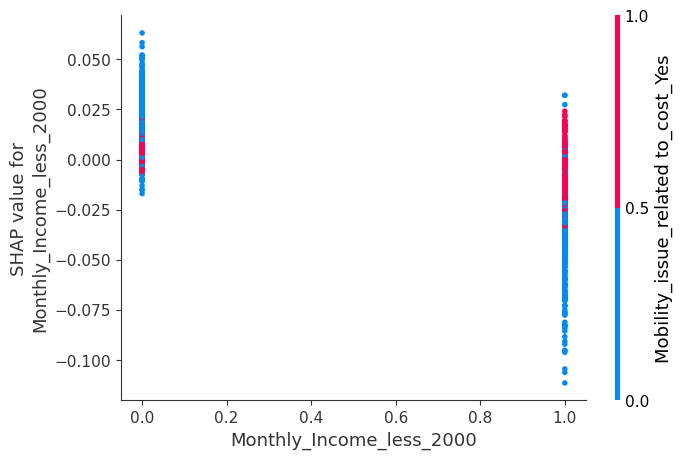

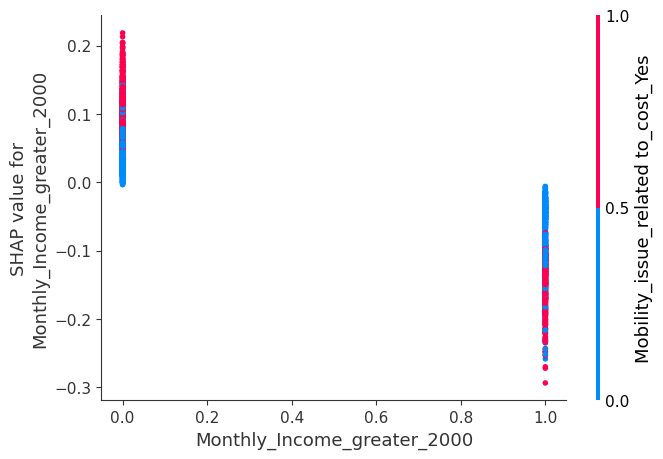

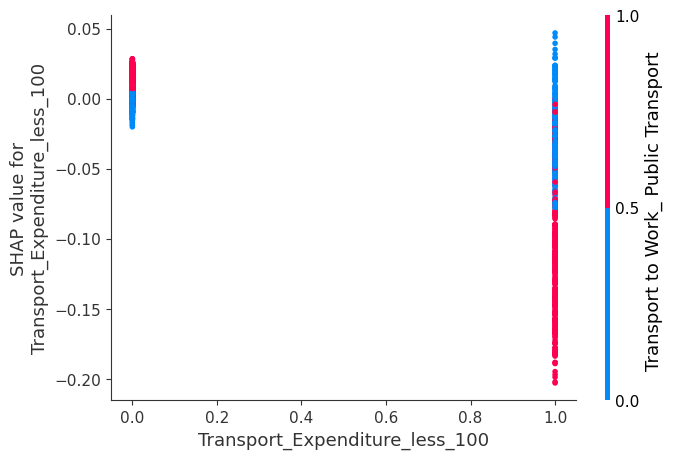

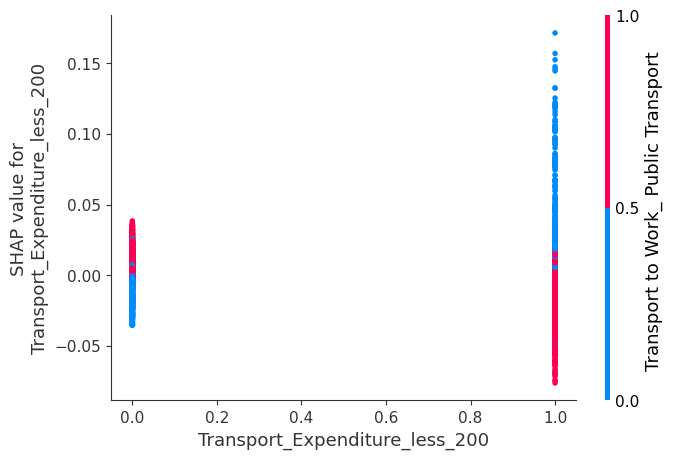

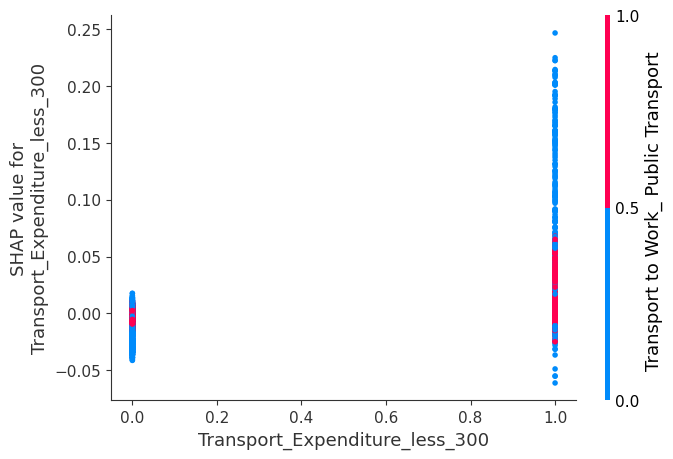

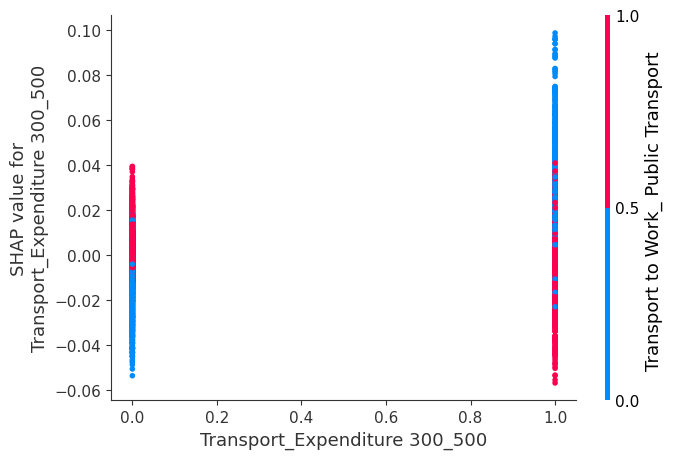

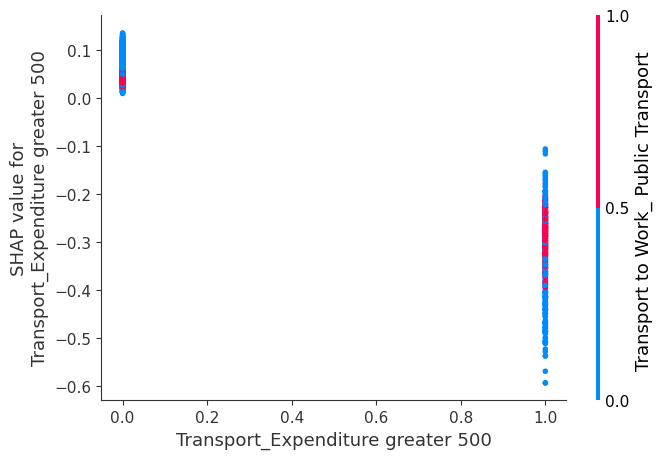

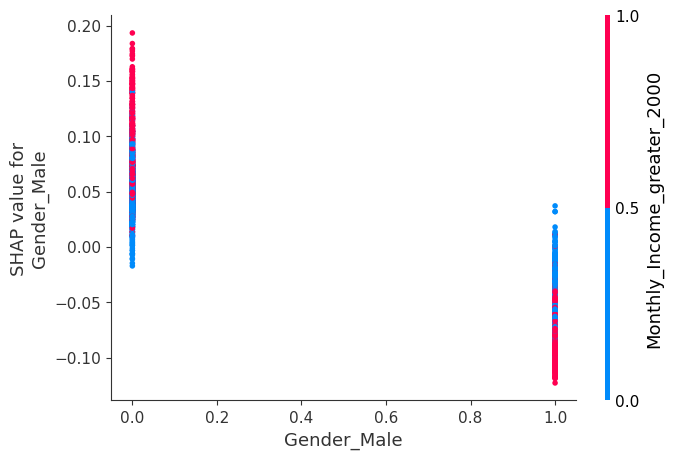

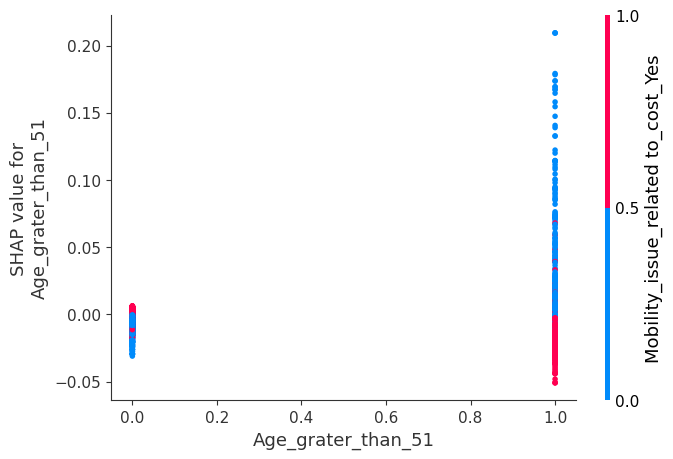

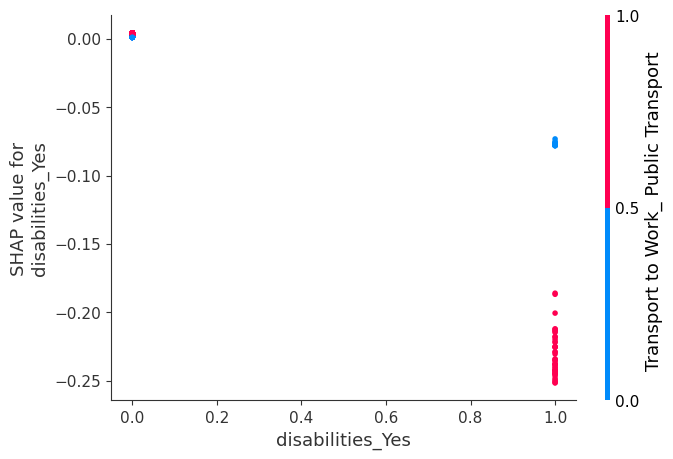

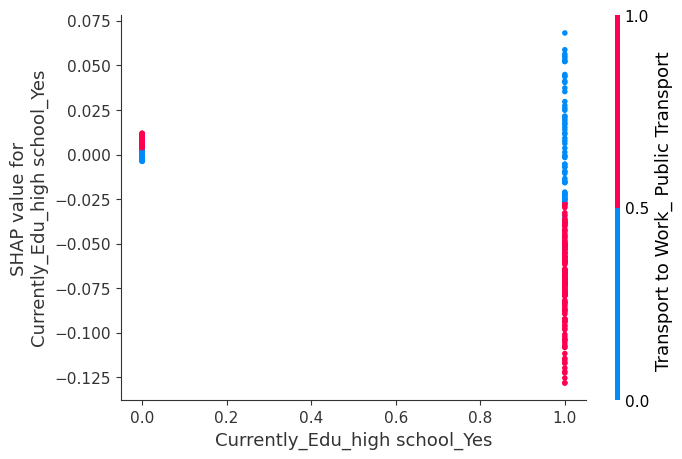

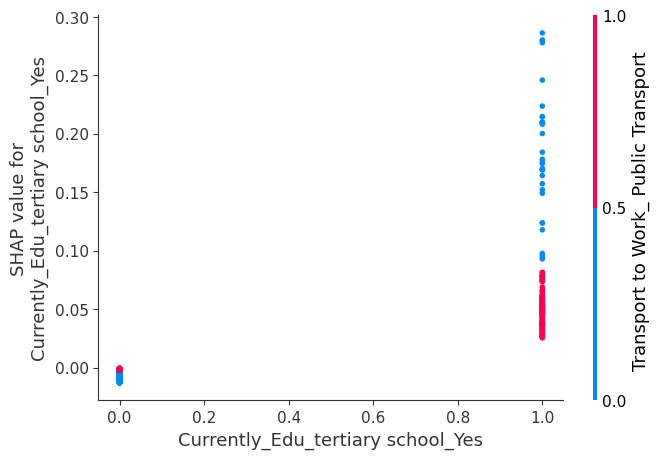

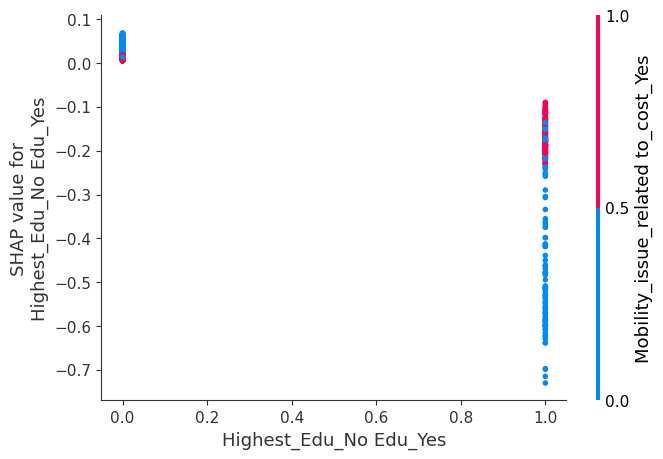

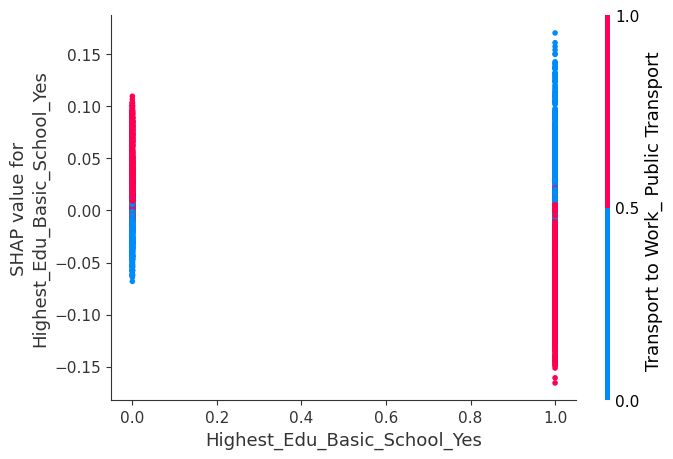

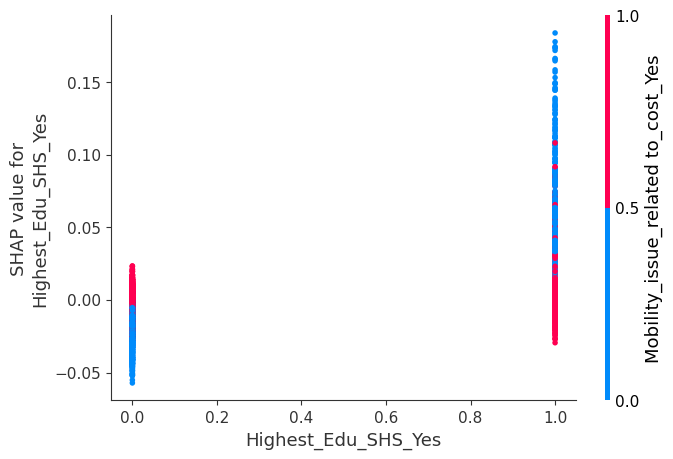

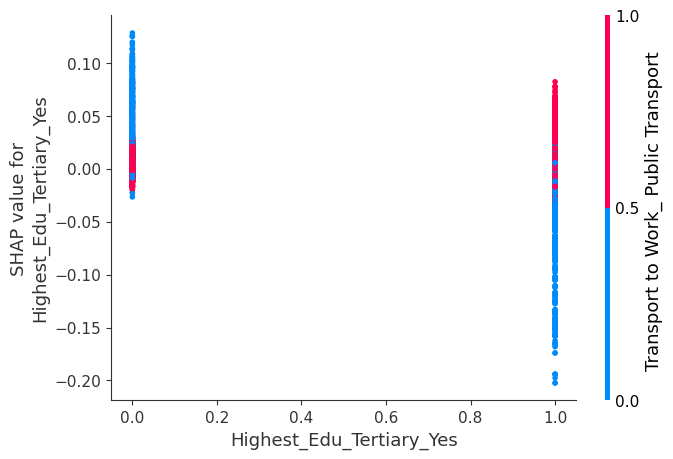

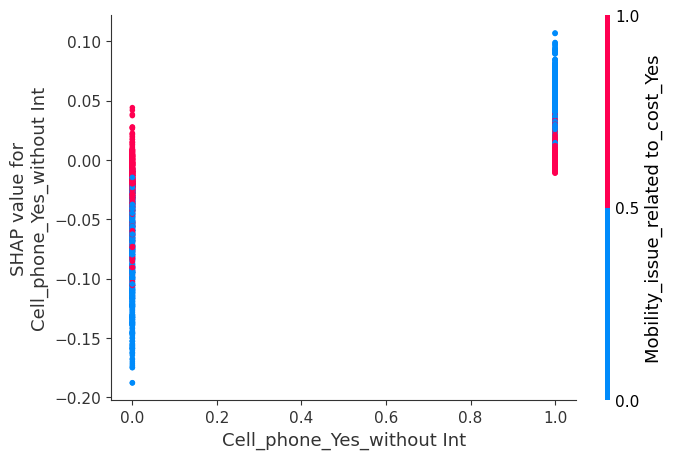

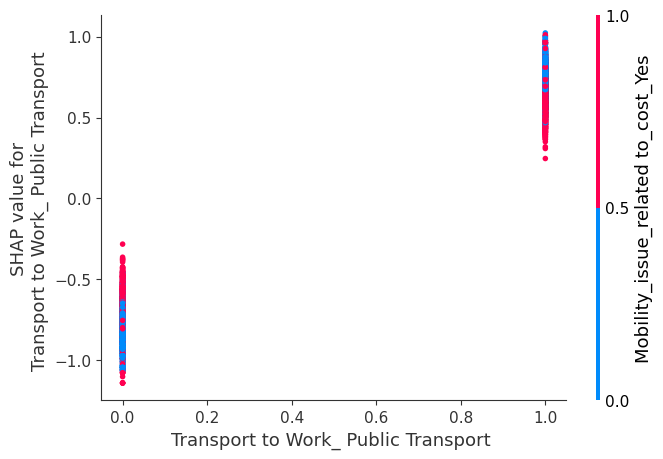

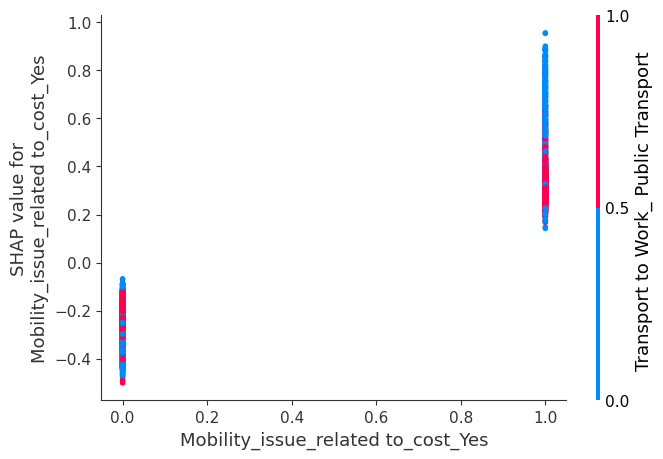

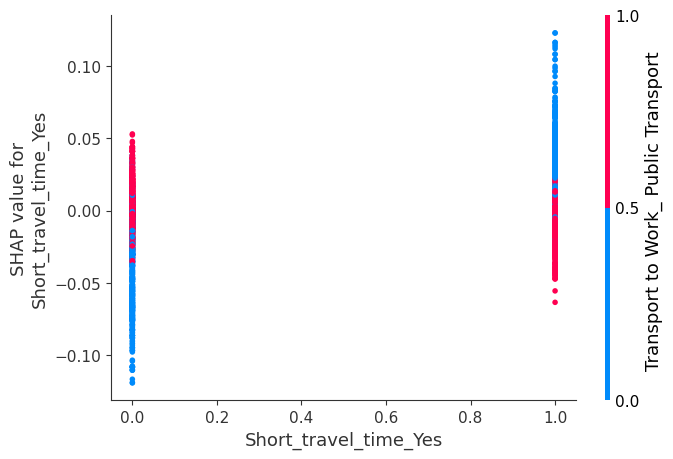

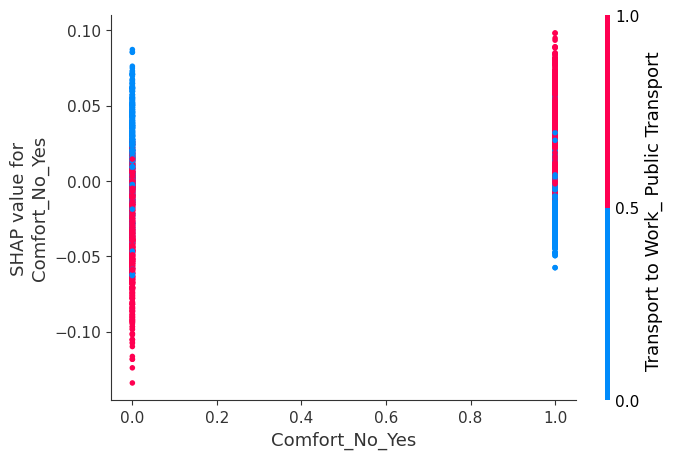

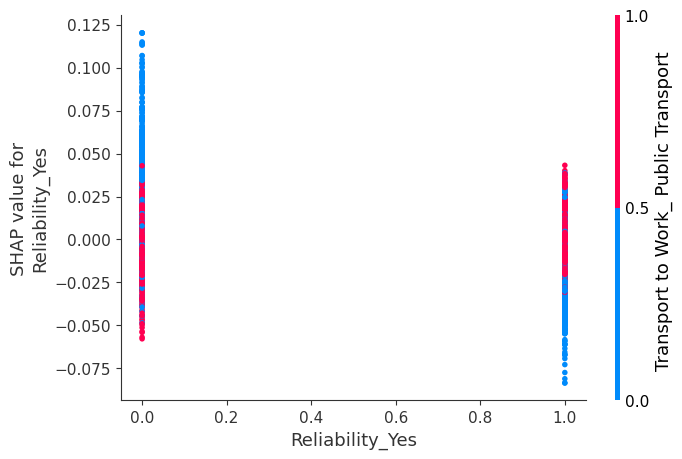

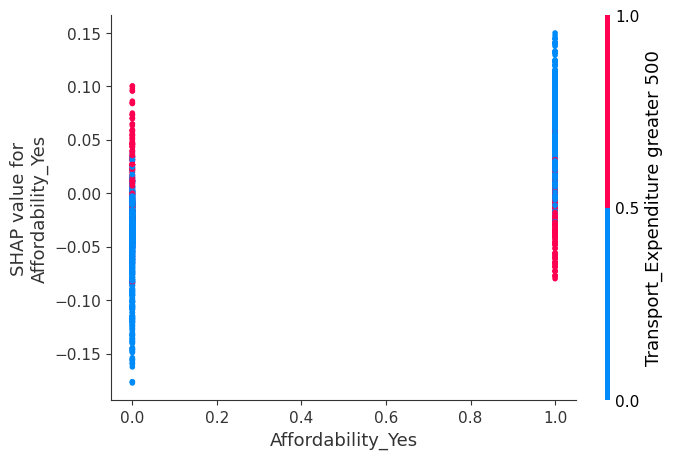

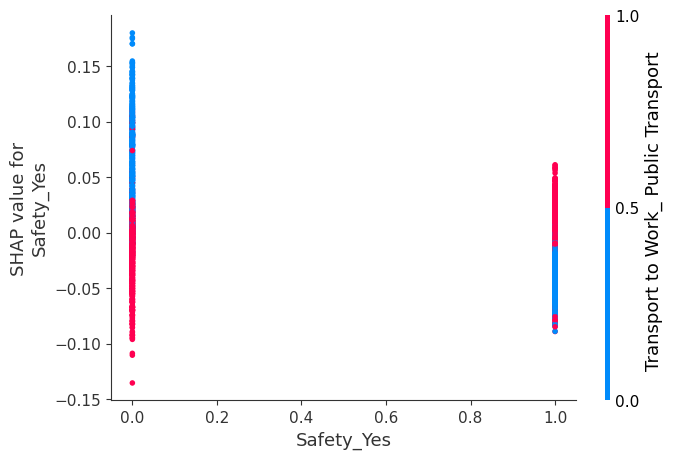

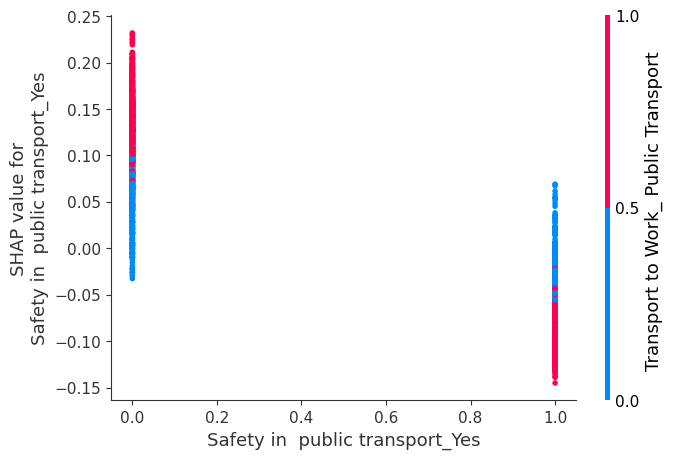

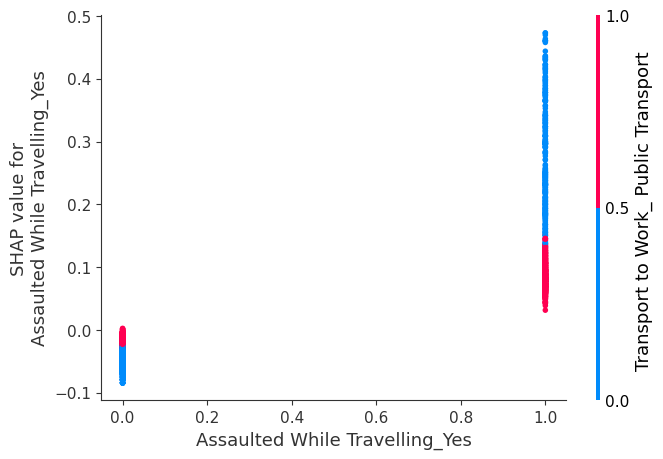

In [16]:
# SHAP dependence plots for each feature
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)


### Introducing SMOTE

In [18]:
import matplotlib.pylab as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
)
from imblearn.over_sampling import SMOTE
import shap

In [19]:

# Display SHAP JS plots
shap.initjs()

# Show all columns
pd.set_option('display.max_columns', None)

# Load data
df = pd.read_csv(r"C:\Users\dzinyela_1\Downloads\Zakari\Personal_Household_Cleaned_ready.csv")

df.drop(['Household_Size_2',
    'Household_Size_3',
    'Household_Size_Above 3',
    'No_Vehicles _Owned',
    'Driving_licence_Yes',
    'Currently_Edu_Basic school_Yes',
    'Currently_Edu_Not Edu_Yes',
    'Age_less_equal_15',
    'Cell_phone_Yes_with Int.','household_Head_Yes','Age_less_equall_51','Age_less_equall_to_31','Vehicle_Access_Yes'
], axis=1, inplace=True)


# Features and target
X = df.drop('Switch_BRT_Yes', axis=1)
y = df['Switch_BRT_Yes']
X_display = X.copy()  # for SHAP display

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Apply SMOTE to handle imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create DMatrix for XGBoost
d_train = xgboost.DMatrix(X_train_resampled, label=y_train_resampled)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [20]:
# Set XGBoost parameters
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train_resampled),
    "eval_metric": "logloss",
}

In [21]:

# Train model
model = xgboost.train(
    params,
    d_train,
    5000,
    evals=[(d_test, "test")],
    verbose_eval=100,
    early_stopping_rounds=20,
)


[0]	test-logloss:0.68855
[100]	test-logloss:0.49108
[200]	test-logloss:0.44694
[300]	test-logloss:0.41798
[400]	test-logloss:0.39521
[500]	test-logloss:0.38057
[600]	test-logloss:0.37178
[700]	test-logloss:0.36608
[800]	test-logloss:0.36233
[900]	test-logloss:0.36100
[949]	test-logloss:0.36071


In [22]:
# Predict on test set
y_pred_prob = model.predict(d_test)
y_pred = (y_pred_prob > 0.5).astype(int)

In [23]:
# Evaluation metrics
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[ 33  51]
 [ 85 755]]


In [24]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.39      0.33        84
           1       0.94      0.90      0.92       840

    accuracy                           0.85       924
   macro avg       0.61      0.65      0.62       924
weighted avg       0.88      0.85      0.86       924



In [25]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)

In [26]:
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC Score: {auc_score:.4f}")



Accuracy: 0.8528
Recall: 0.8988
AUC Score: 0.7399


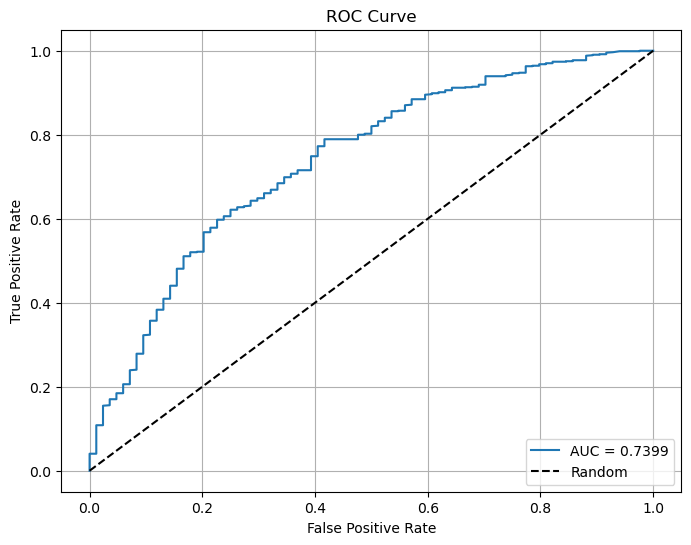

In [27]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [28]:
# SHAP analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

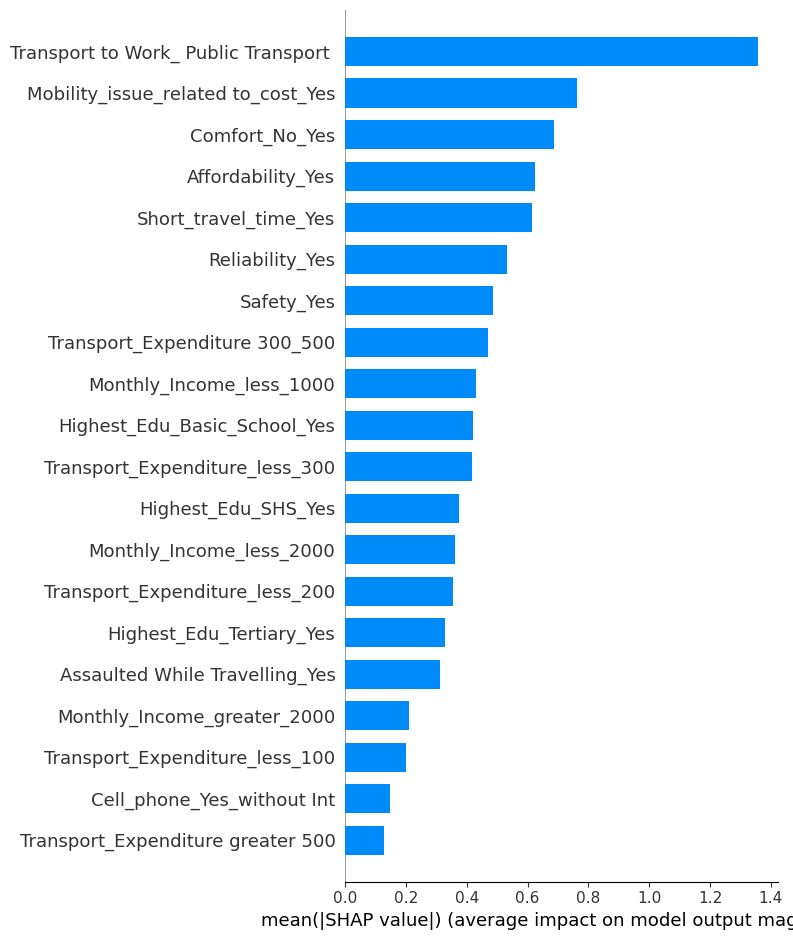

In [29]:
# SHAP plots
shap.summary_plot(shap_values, X_display, plot_type="bar")


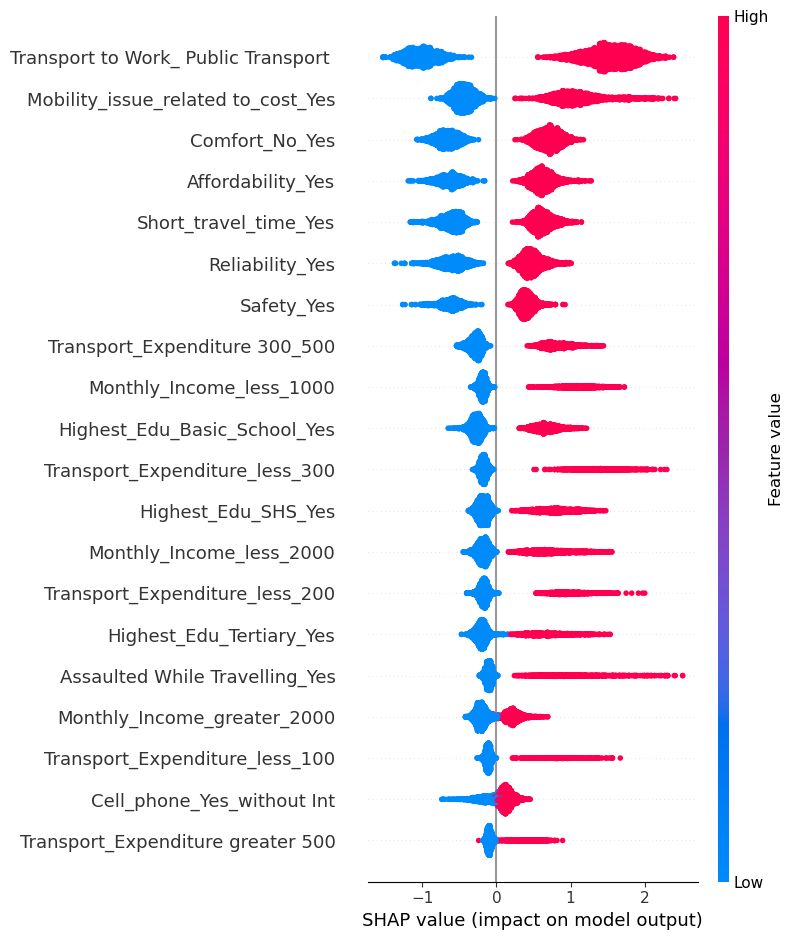

In [30]:
shap.summary_plot(shap_values, X)

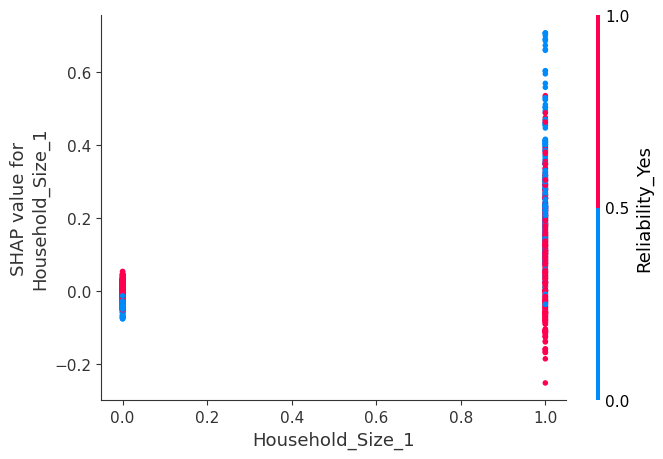

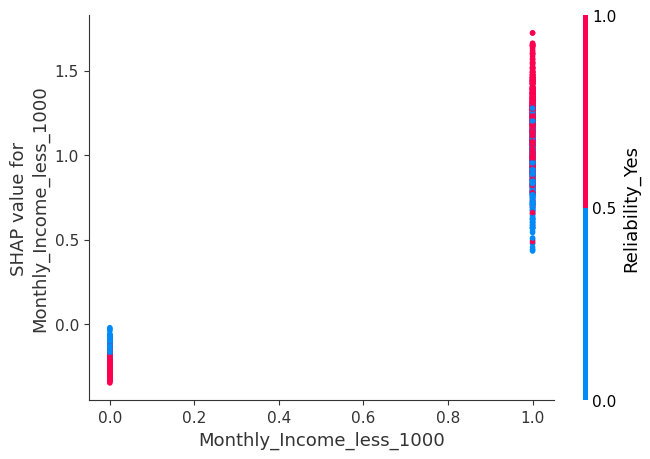

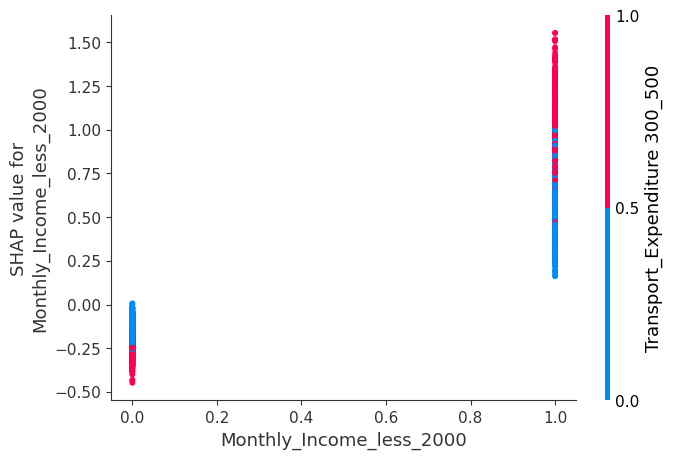

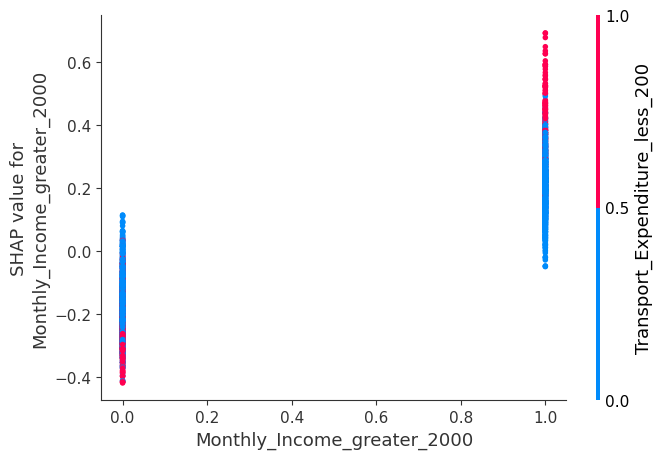

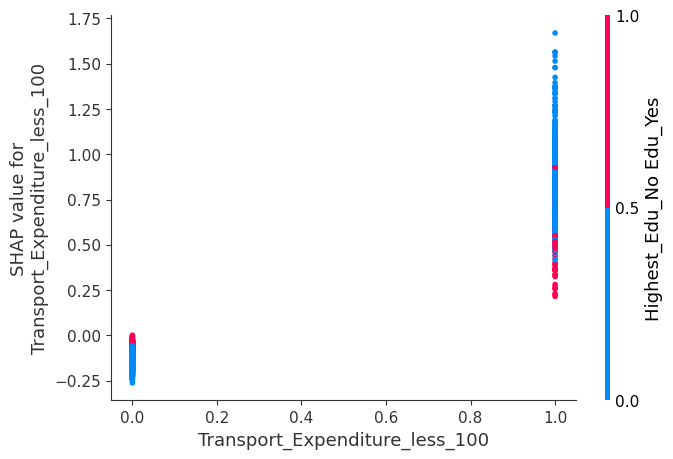

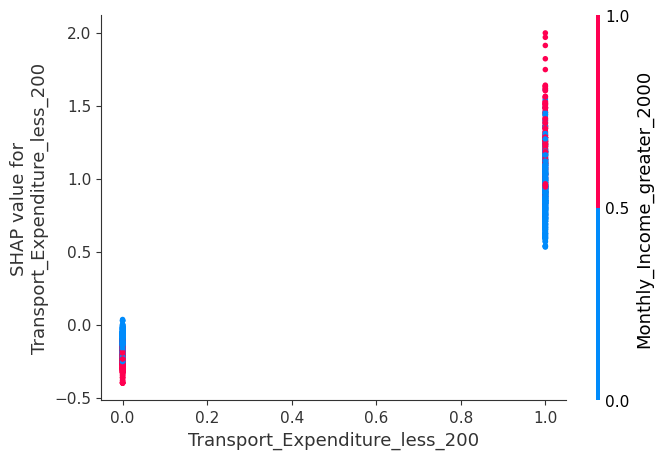

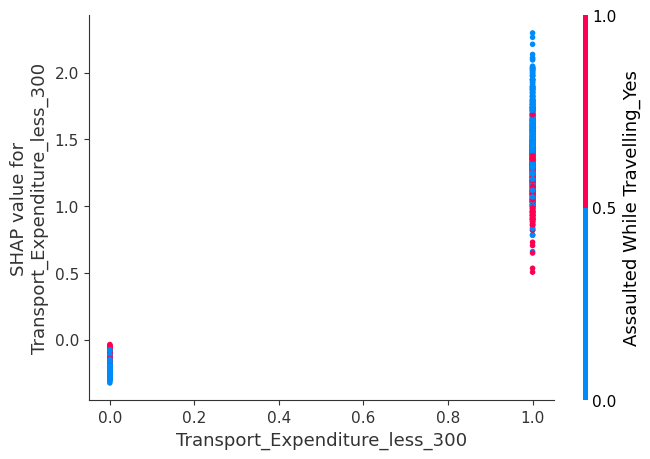

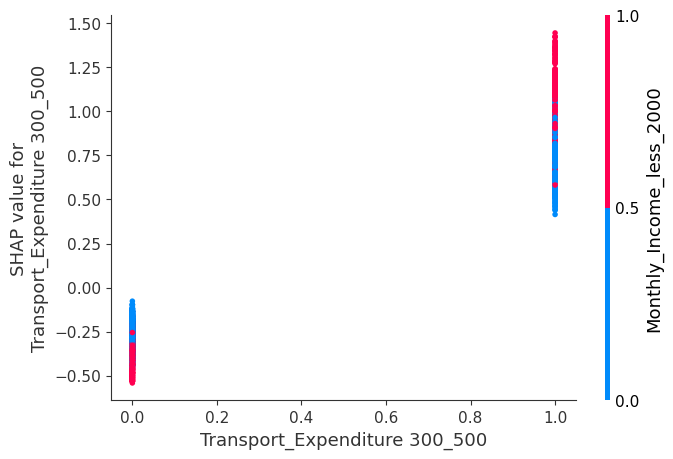

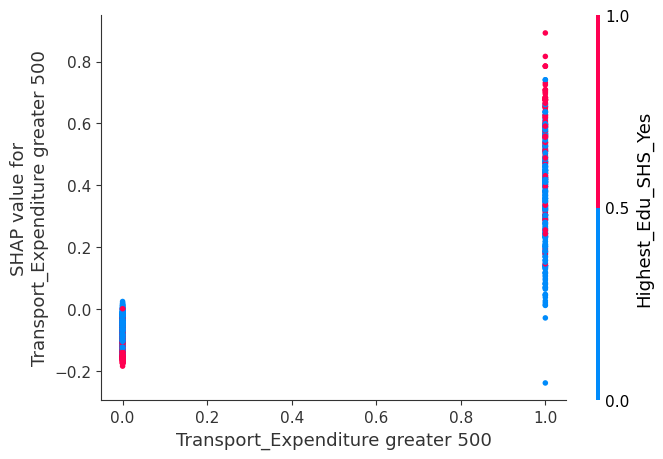

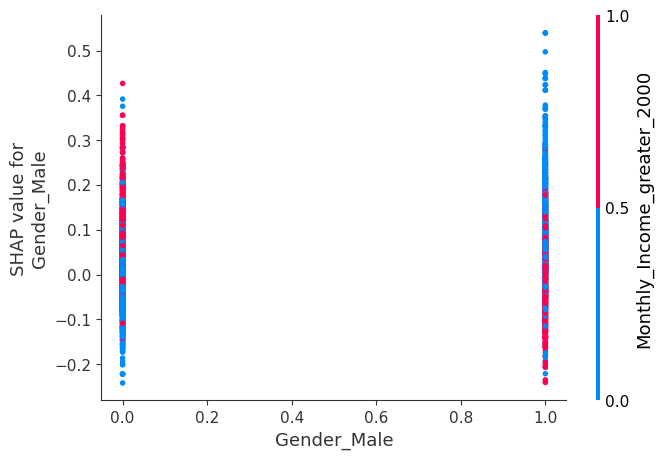

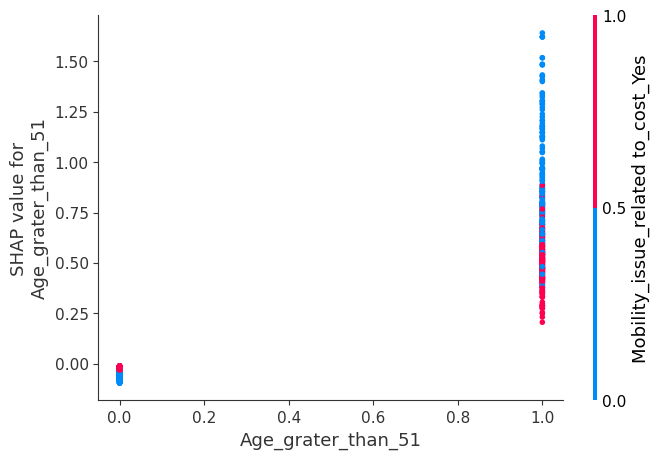

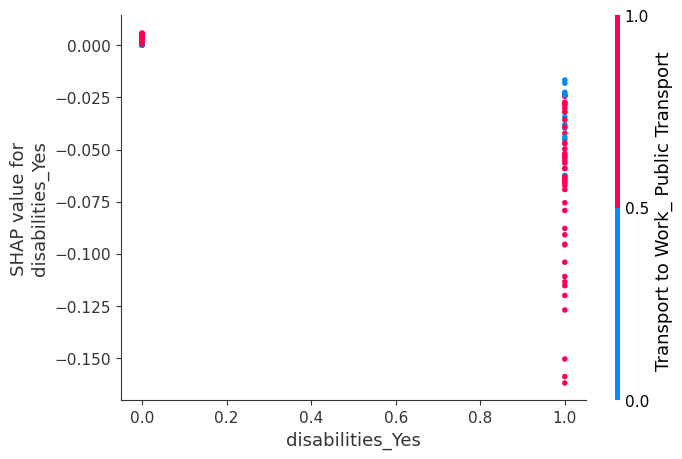

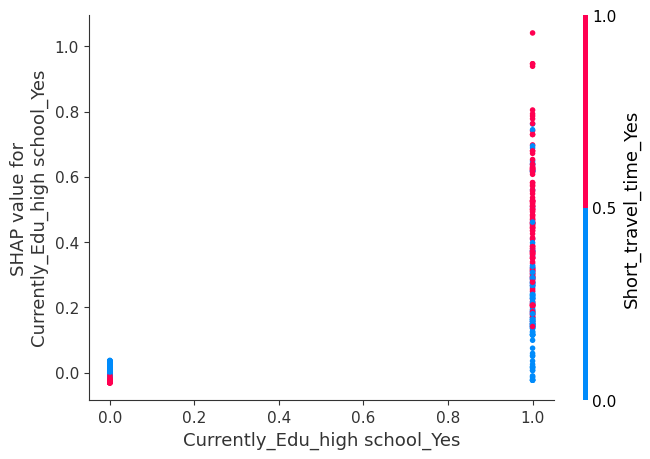

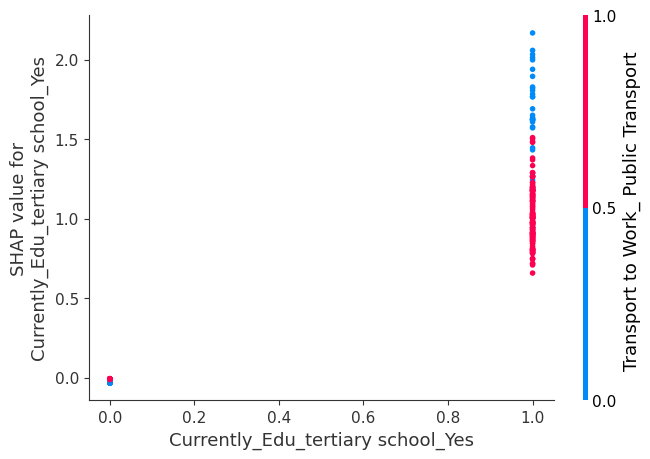

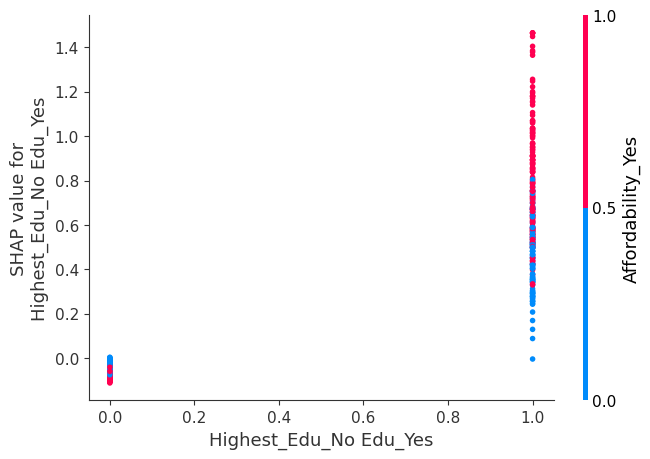

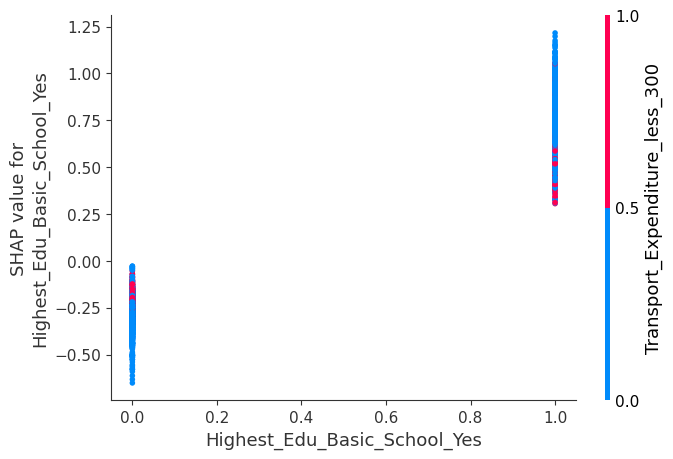

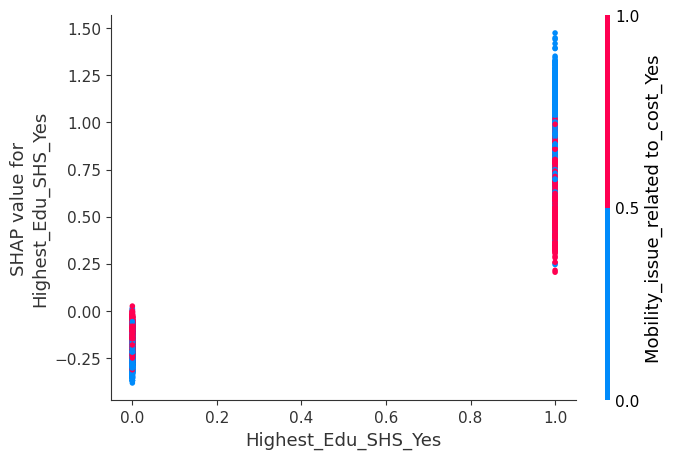

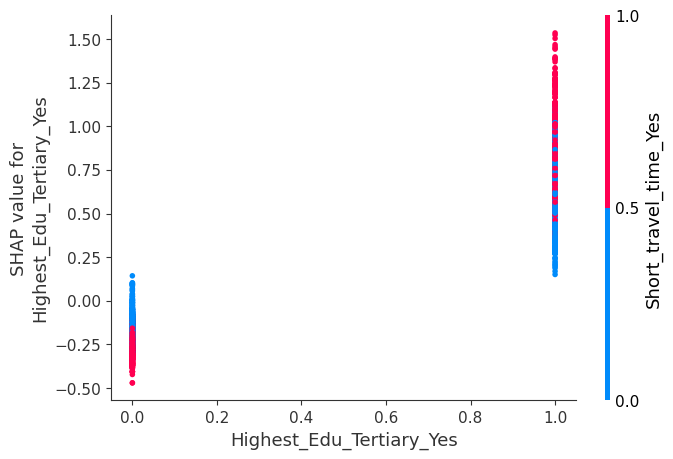

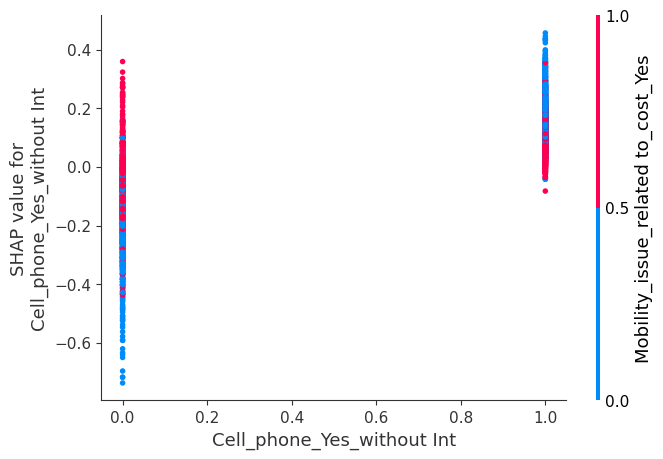

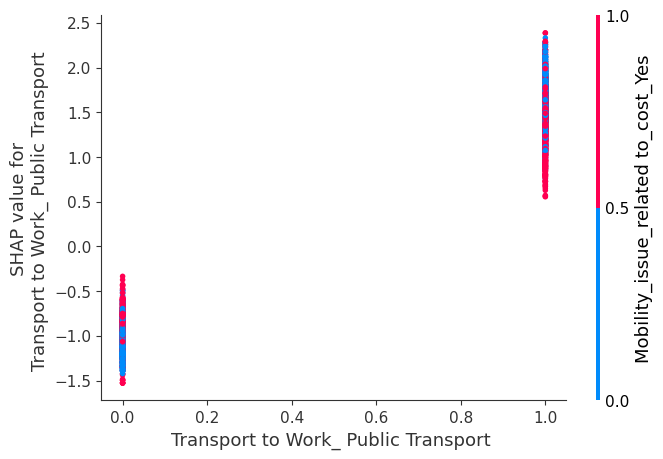

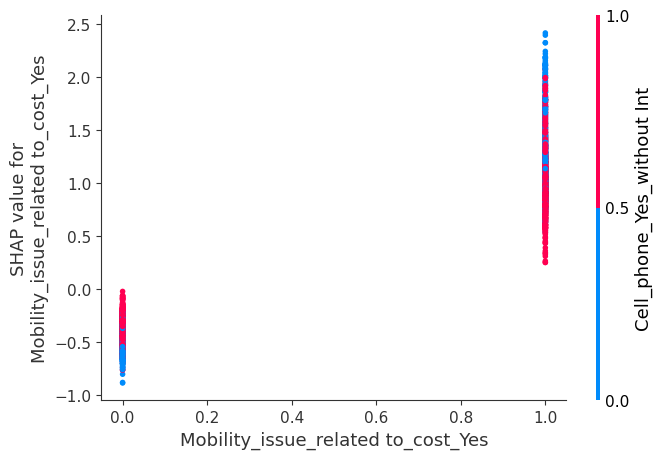

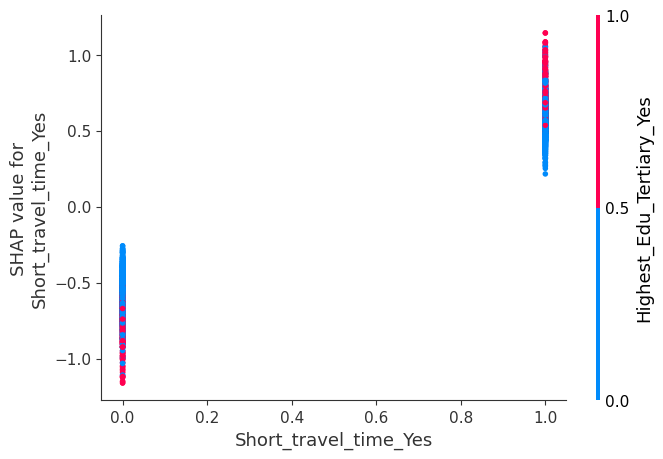

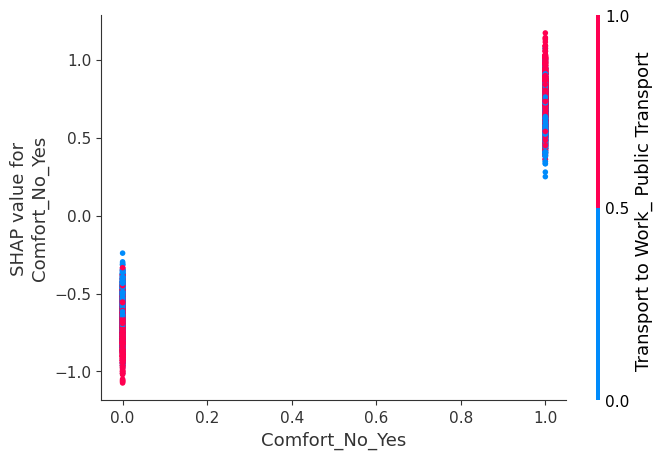

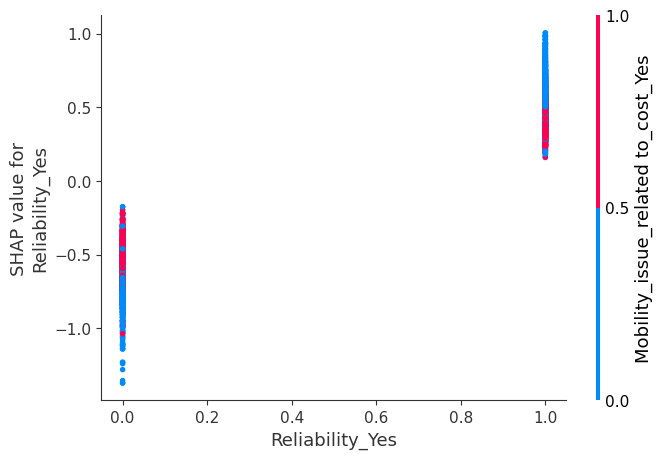

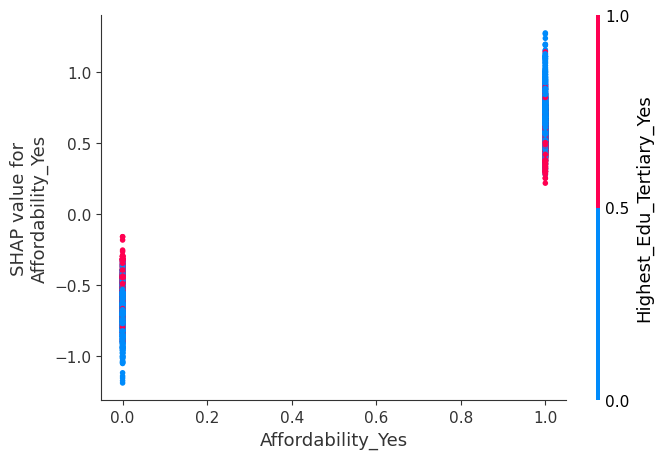

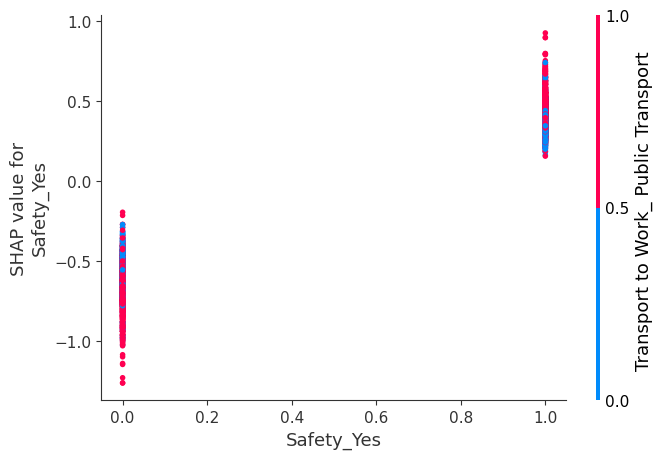

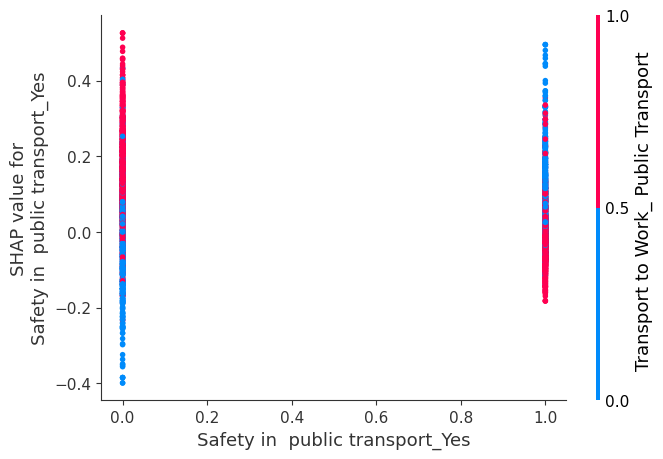

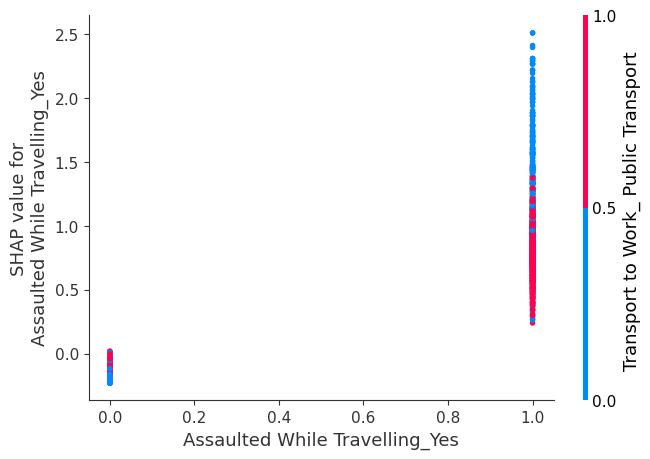

In [34]:
# SHAP dependence plots for each feature
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)
